In [ ]:
## the following code refers to the VGG16 downloading.........

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG16(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16, self).__init__()
        vgg = models.vgg16(pretrained=pretrained)
        self.features = vgg.features[:-1]  # remove the last maxpool layer
        for i, param in enumerate(vgg.parameters()):
          if i<22:
             param.requires_grad = False
          else:
             param.requires_grad = True
        

    def forward(self, x):
        x = self.features(x)
        return x




Initially RPN network was trained for 40 epochs, then frezed its parameters, and let fast rcnn trains 

In [31]:


import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.nn.init as init

class rpn_head(nn.Module):
  def __init__(self, in_channels=512, mid_channel=512, num_anchors=9):             
      super(rpn_head, self).__init__()
      self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
      self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1, stride=1)
      self.bbox_pred = nn.Conv2d(in_channels, num_anchors*4, kernel_size=1, stride=1)
      self.classifier = nn.CrossEntropyLoss( reduction='mean')
      init.xavier_uniform_(self.conv.weight)
      init.xavier_uniform_(self.cls_logits.weight)
      init.xavier_uniform_(self.bbox_pred.weight)
      for layer in self.children():
        if isinstance(layer, nn.Conv2d):
          torch.nn.init.normal_(layer.weight, std=0.01)
          torch.nn.init.constant_(layer.bias, 0)
         
      
      for parm in self.conv.parameters():
          parm.requires_grad = False

      for parm in self.cls_logits.parameters():
          parm.requires_grad = False

      for parm in self.bbox_pred.parameters():
          parm.requires_grad = False
      
  def forward(self, feature_map, anchors, targets, offsets, labels, weights, valid_anchors,  images):
      x = F.relu(self.conv(feature_map))
      pred_offsets = self.bbox_pred(x).permute(0, 2, 3, 1).reshape(len(feature_map), -1, 4)
      pred_cls_scores = self.cls_logits(x).permute(0,2,3,1).reshape(len(feature_map), -1)
      
      
      
      
      anchors_candidates, positives_cands = self.Select_Training_Anchors(labels, pred_cls_scores, valid_anchors)
      proposed_labels, proposed_regions, indices, positive_indx, fast_offsets = self.Select_training_anchors_fastrcnn(
                                          labels, anchors, pred_offsets.detach(), pred_cls_scores.detach(), weights, valid_anchors, offsets, targets)
      '''
      Just to test if the bounding boxes are well orginized 
      ##
      print(len(anchors))
      img = images[0].to(torch.device('cpu')).numpy().transpose(1,2,0).copy()
      for a_can in proposed_regions[0][positive_indx[0]]:
          
          #img = images[0].to(torch.device('cpu')).numpy().transpose(1,2,0).copy()
          
          box = a_can.detach().cpu().numpy()
          print(box)
          x1 = int(box[0])
          y1 = int(box[1])
          x2 = int(box[2])
          y2 = int(box[3])
          cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
      plt.imshow(img)
      
      '''

      rpn_losses = self.Loss(pred_offsets, offsets, pred_cls_scores, 
                        labels, anchors_candidates, positives_cands, valid_anchors)
      
      
      return {'rpn_losses':rpn_losses, 'to_fastrcnn' : {'proposed_labels':proposed_labels,
                                                      'indices':indices, 'proposed_regions':proposed_regions, 
                                                      'positive_indx':positive_indx,
                                                      'fast_offsets':fast_offsets} }
      
  
  def Select_Training_Anchors(self, labels, pred_scores, valid_anchors):

      contributed_anchors, positives_candidates = [], []

      for indx, label_batch in enumerate(labels):
          positive_labels = torch.where(label_batch > 0)[0]
          negative_labels = torch.where(label_batch == 0)[0]

          if positive_labels.numel() > 16:
             ## hard mining to target the most samples that may disclassified 
             _, hard_mining_positive_indices = torch.topk( pred_scores[indx][valid_anchors][positive_labels].view(-1), k=16, largest=True )
             
             _, hard_mining_negative_indices = torch.topk( pred_scores[indx][valid_anchors][negative_labels].view(-1), k=240, largest=True )
             
             contributed_anchors.append(torch.cat( (positive_labels[hard_mining_positive_indices], 
                                                    negative_labels[hard_mining_negative_indices]) ))
             positives_candidates.append(positive_labels[hard_mining_positive_indices])

          else:

            _, hard_mining_negative_indices = torch.topk(pred_scores[indx][valid_anchors][negative_labels].view(-1),
                                            k=256 - positive_labels.numel(), largest=True )
            
            contributed_anchors.append(torch.cat( (positive_labels, negative_labels[hard_mining_negative_indices]) ))
            positives_candidates.append(positive_labels)
            
              
              
        
      return contributed_anchors, positives_candidates

  def Select_training_anchors_fastrcnn(self, labels, anchors, pred_offsets, pred_cls_scors, 
                                       weights, valid_anchors, offsets, targets):

      proposed_regions, proposed_labels, indices, positive_indices, fast_offsets_list = [], [], [], [], []
      decoded_boxes = decode_boxes(torch.stack((pred_offsets[0][valid_anchors] , pred_offsets[1][valid_anchors]),dim=0),
                                               anchors.unsqueeze(0), weights)
      
      fast_labels, assinged_fast_boxes = assign_anchors_to_bboxes(decoded_boxes, targets, fast=True)
      fast_offsets = encode_boxes(assinged_fast_boxes, decoded_boxes, weights)
      
      for indx, pred_cls in enumerate(pred_cls_scors):

          
          
          positive_pred = torch.where( pred_cls[valid_anchors] > 0.0)[0]
          positive_labels = torch.where(fast_labels[indx][positive_pred] == 1)[0]
          positive_labels = positive_pred[positive_labels]

          negative_pred = torch.where( pred_cls[valid_anchors] < 0.0)[0]
          negative_labels = torch.where(fast_labels[indx][negative_pred] == 0)[0]
          negative_labels = negative_pred[negative_labels]
          
          
          
          if  len(positive_labels) >= 16 :
            
              _, hard_mining_positive_indices = torch.topk(pred_cls[valid_anchors][positive_labels].view(-1), k=16, largest=True)
              _, hard_mining_negative_indices = torch.topk(pred_cls[valid_anchors][negative_labels].view(-1), k = 112, largest=False)

              concated_indices = torch.cat( (positive_labels[hard_mining_positive_indices], 
                                           negative_labels[hard_mining_negative_indices]) )
              
              
              indices.append(concated_indices)   
              proposed_labels.append( fast_labels[indx][concated_indices] )
              fast_offsets_list.append(fast_offsets[indx][concated_indices])
              proposed_regions.append(decoded_boxes[indx][concated_indices])
              positive_indices.append(torch.arange(16).to(torch.long))  
          
          else:
            
              _, hard_mining_negative_indices = torch.topk(pred_cls[valid_anchors][negative_labels].view(-1),
                                                           k = 128 - positive_labels.numel(),largest=False)
              
              concated_indices = torch.cat( (positive_labels,
                                           negative_labels[hard_mining_negative_indices]) )
              indices.append(concated_indices)
              proposed_labels.append( fast_labels[indx][concated_indices] )

              fast_offsets_list.append(fast_offsets[indx][concated_indices])
              proposed_regions.append(decoded_boxes[indx][concated_indices])
              positive_indices.append( torch.arange(len(positive_labels), dtype=torch.long))      

      return proposed_labels, proposed_regions, indices, positive_indices, fast_offsets_list

            
  
  def Loss(self, pred_offsets, offsets, pred_cls, labels, anchor_candidates, positives_cands, valid_anchors):

      
      pred_offsets = torch.cat( (pred_offsets[0][valid_anchors][positives_cands[0]], pred_offsets[1][valid_anchors][positives_cands[1]]) )
      
      
      choosen_offsets = torch.cat( (offsets[0][positives_cands[0]] , offsets[1][positives_cands[1]]) )
      
      pred_cls = torch.cat ( (pred_cls[0][valid_anchors][anchor_candidates[0] ], pred_cls[1][valid_anchors][anchor_candidates[1]]) )
      labels = torch.cat( (labels[0][anchor_candidates[0]], labels[1][anchor_candidates[1]]) )
      
      classifier = F.binary_cross_entropy_with_logits(pred_cls, labels)
      

      if len(choosen_offsets) == 0:
         bbox_regression = torch.tensor(0.0, device=choosen_offsets.device,
                                        dtype=choosen_offsets.dtype)
      else:   
         bbox_regression = F.smooth_l1_loss(pred_offsets, choosen_offsets,beta=1/9,
                                         reduction='sum')/max(1, pred_offsets.numel())

      loss = classifier + bbox_regression
      

      return {'loss':loss, 'bbox_regression':bbox_regression, 'classifier':classifier}



In [61]:

import torch.nn as nn
import torch


import torch.nn.functional as F

class Fast_RCNN(nn.Module):
    def __init__(self, in_channels=512, level=[7]):
        super(Fast_RCNN, self).__init__()
    
        feature_dim = level[0] * level[0] * in_channels
        self.FC1 = nn.Linear(in_features=feature_dim, out_features=1024)
        self.FC2 = nn.Linear(in_features=1024, out_features=1024)

        self.cls_score = nn.Linear(1024, 2)
        self.bbox = nn.Linear(1024, 4)

        

        init.xavier_uniform_(self.FC1.weight)
        init.xavier_uniform_(self.FC2.weight)
        init.xavier_uniform_(self.cls_score.weight)
        init.xavier_uniform_(self.bbox.weight)

        self.loss_func = nn.CrossEntropyLoss( )

    def forward(self, feature_map, rpn_output):
    
        if self.training:

            proposals_bbox, proposals_labels = rpn_output['proposed_regions'], rpn_output['proposed_labels']
            positive_indices, fast_offsets = rpn_output['positive_indx'], rpn_output['fast_offsets']
            roi_output = roi_pooling(feature_map, proposals_bbox, pool_size=torch.Size((7,7)))
            
            feat = F.relu(self.FC1(roi_output.view(roi_output.shape[0]*roi_output.shape[1], -1)))
            feat = F.relu(self.FC2 (feat) )
            pred_scores  = self.cls_score(feat).view(2, -1, 2)
            pred_offsets = self.bbox(feat).view(2,-1, 4)

            fastrcnn_losses = self.loss( pred_offsets, pred_scores, positive_indices ,proposals_labels, fast_offsets)
            
            return {'fastrcnn_losses':fastrcnn_losses}



    def loss(self, pred_offsets, pred_scores, positive_indices ,proposals_labels, offsets):
      
        concat_pred_offsets = torch.cat(  (pred_offsets[0][positive_indices[0]] ,
                                 pred_offsets[1][positive_indices[1]]) )
        concat_offsets = torch.cat( (offsets[0][ positive_indices[0] ], offsets[1][positive_indices[1] ]) )
        
        pred_cls = pred_scores.view(-1,2)
        labels = torch.cat(proposals_labels, dim=0)

        num_classes = 2
        labels = torch.eye(num_classes).to(device=pred_cls.device)[labels.to(torch.long)]
        classifier = self.loss_func(pred_cls, labels)
          
        if len(concat_offsets) == 0:
           bbox_regression = torch.tensor(0.0, device=concat_offsets.device,
                                          dtype=concat_offsets.dtype)

        else:
           bbox_regression = F.smooth_l1_loss(concat_pred_offsets, concat_offsets, beta=1/9,
                                           reduction='sum')/max(1, concat_offsets.numel())
        
        loss = bbox_regression + classifier
        
        return {'loss':loss, 'bbox_regression':bbox_regression, 'classifier':classifier}       


In [35]:
import torch
import matplotlib.pyplot as plt
import cv2
class Faster_RCNN(nn.Module):
  def __init__(self, device=torch.device('cpu'), sizes=[[32], [64], [256]]):
      super(Faster_RCNN, self).__init__()

      self.backbone = VGG16()
      self.anchors_generation = anchor_generation(device=device, sizes=sizes)
      self.rpn_network = rpn_head()
      self.fast_rcnn = Fast_RCNN()
      self.weights = (1.0, 1.0, 1.0, 1.0)

  def forward(self, images, targets = None):
      features = self.backbone(images)
      anchors = self.anchors_generation(features)
      
      valid_anchors_indices = torch.where( (anchors[:,0]>=0) & (anchors[:,1] >= 0) & (anchors[:,2] >= 0) & (anchors[:,3] >= 0) &
                                          (anchors[:,2]<=600) & (anchors[:,3]<=600))
      valid_anchors_indices = torch.where( ( (anchors[valid_anchors_indices][:, 3] - anchors[valid_anchors_indices][:,1])>=60  )&
                                          ((anchors[valid_anchors_indices][:,2] - anchors[valid_anchors_indices][:,0])>=60))
      anchors_tow = torch.stack(( anchors[valid_anchors_indices], anchors[valid_anchors_indices]), dim=0)
      anchors = anchors[valid_anchors_indices]

      
      
      
      assigned_labels, assigned_boxes = assign_anchors_to_bboxes(anchors_tow, targets)
      
      '''
      ## these commented lines is just to visulize if the data is well orgnized 
      for labes, bos in zip(assigned_labels, assigned_boxes):
          im = images[0].to(torch.device('cpu')).numpy().transpose(1,2,0).copy()
          #print(im)
          pos = torch.where(labes==1)[0]
          print("assigned_labels", pos)
          print(pos)
          print(bos[pos])
          for bo in anchors[0][pos]:
              x1 = int(bo[0])
              y1 = int(bo[1])
              x2 = int(bo[2])
              y2 = int(bo[3])
              cv2.rectangle(im, (x1,y1), (x2,y2),(0,255,0),2)
          plt.imshow(im)
          print(n) 
      '''

      offsets = encode_boxes(assigned_boxes, anchors.unsqueeze(0), self.weights)

      if self.training:
        
        features = self.backbone(images)

        rpn_output = self.rpn_network(features, anchors, targets, offsets, assigned_labels, self.weights, valid_anchors_indices, images)
        
        fast_rcnn_output = self.fast_rcnn(features, rpn_output['to_fastrcnn'])
        
        return rpn_output, fast_rcnn_output






      else:
        return 'this part of refer to testing'
 




In [29]:
t= torch.tensor([6])
print(t.dtype)

torch.int64


In [7]:
class anchor_generation(nn.Module):
  def __init__(self, device=torch.device('cpu'),
                sizes=[[64],[128],[256],[512]] ):
    super(anchor_generation, self).__init__()
    self.device = device
    aspect_ratios = [[0.5, 1, 2],] * len(sizes)
    
    self.cell_anchors = [ self.generate_anchors(size,aspect_ratio,device=self.device)
                          for size, aspect_ratio in zip(sizes, aspect_ratios) ]
    
  
  def generate_anchors(self, scales, aspect_ratio,dtype: torch.dtype = torch.float32,
                       device: torch.device = torch.device('cpu')):
    
    scales = torch.as_tensor(scales, dtype=dtype, device=device)
    as_ratios = torch.as_tensor(aspect_ratio, dtype=dtype, device=device)
    h_ratios = torch.sqrt(as_ratios)
    w_ratios = 1 / h_ratios
    
    ws = (w_ratios.unsqueeze(1) * scales.unsqueeze(0)).view(-1)
    hs = (h_ratios.unsqueeze(1) * scales.unsqueeze(0)).view(-1)

    base_anchors = torch.stack([-ws, -hs, ws, hs])
    
    
    return base_anchors.round().T.to(torch.float32)
  
  def grid_anchors(self, grid_sizes, strides):
    anchors = []
    
    for base_anchors in self.cell_anchors:
      
      grid_height, grid_width = grid_sizes
      stride_height, stride_width = strides
      shifts_x = torch.arange(0, grid_width, dtype=torch.float32, device=self.device) * stride_width
      shifts_y = torch.arange(0, grid_height, dtype=torch.float32, device=self.device) * stride_height

      shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
      shift_x = shift_x.reshape(-1)
      shift_y = shift_y.reshape(-1)
      shifts = torch.stack((shift_x, shift_y, shift_x, shift_y), dim=1)
           
      anchors.append(( shifts.view(-1,1,4) + base_anchors.view(1,-1, 4)).reshape(-1,4))
    
    return anchors
    
  def forward(self, feature_maps):
      grid_sizes = [feature_map.shape[-2:] for feature_map in feature_maps]     
      new_grid_sizes = list( torch.tensor([16,16]).to(torch.int) )
      
      image_size = [600, 600]
      dtype, device = feature_maps[0].dtype, feature_maps[0].device
      strides =  [[ torch.tensor(image_size[0]//g[0], dtype=torch.int64, device=device),
                   torch.tensor(image_size[1]//g[1], dtype=torch.int64, device=device)] for g in grid_sizes ]
      
      anchors_over_all_feature_maps = self.grid_anchors(grid_sizes[0], strides[0])
      
      anchors_over_all_feature_maps = torch.cat(anchors_over_all_feature_maps)
      return anchors_over_all_feature_maps


In [8]:
import torch 
import math
def encode_boxes(reference_boxes, proposals, weights):
  # shape of reference_boxes is [batch_size, number_of_anchors, 4]
  # shape of proposals is [batch_size, number_of_anchors, 4]
  # shape of weights [1,4]
  wx = weights[0]
  wy = weights[1]
  ww = weights[2]
  wh = weights[3]
  

  proposals_x1 = proposals[:, :, 0]
  proposals_y1 = proposals[:, :, 1]
  proposals_x2 = proposals[:, :, 2]
  proposals_y2 = proposals[:, :, 3]

  proposals_width  = proposals_x2 - proposals_x1
  proposals_height = proposals_y2 - proposals_y1
  proposals_ctr_x  = proposals_x1 + 0.5 * proposals_width
  proposals_ctr_y = proposals_y1 + 0.5 * proposals_height


  reference_boxes_x1 = reference_boxes[:, :, 0]
  reference_boxes_y1 = reference_boxes[:, :, 1]
  reference_boxes_x2 = reference_boxes[:, :, 2]
  reference_boxes_y2 = reference_boxes[:, :, 3]

  reference_width = reference_boxes_x2 - reference_boxes_x1
  reference_height = reference_boxes_y2 - reference_boxes_y1
  reference_ctr_x = reference_boxes_x1 + 0.5 * reference_width
  reference_ctr_y = reference_boxes_y1 + 0.5 * reference_height


  targets_dx =  wx * (reference_ctr_x - proposals_ctr_x)/ proposals_width
  targets_dy =  wy * (reference_ctr_y - proposals_ctr_y)/proposals_height
  targets_dw =  ww * torch.log(reference_width / proposals_width)
  targets_dh =  wh * torch.log(reference_height / proposals_height)

  targets = torch.cat( (targets_dx.unsqueeze(2), targets_dy.unsqueeze(2), 
                        targets_dw.unsqueeze(2), targets_dh.unsqueeze(2)), dim=2)

  return targets

def decode_boxes(predicted_boxes, proposals, weights):
  wx = weights[0]
  wy = weights[1]
  ww = weights[2]
  wh = weights[3]

  proposals_x1 = proposals[:,:,0]
  proposals_y1 = proposals[:,:,1]
  proposals_x2 = proposals[:,:,2]
  proposals_y2 = proposals[:,:,3]
  
  proposals_width = proposals_x2 - proposals_x1
  proposals_height = proposals_y2 - proposals_y1
  proposals_ctr_x = proposals_x1 + 0.5 * proposals_width
  proposals_ctr_y = proposals_y1 + 0.5 * proposals_height

  predicted_x = predicted_boxes[:,:,0]/wx
  predicted_y = predicted_boxes[:,:,1]/wy
  predicted_w = predicted_boxes[:,:,2]/ww
  predicted_h = predicted_boxes[:,:,3]/wh

  predicted_w = torch.clamp(predicted_w, max=math.log(1000./16))
  predicted_h = torch.clamp(predicted_h, max=math.log(1000./16))

  pred_ctr_x = predicted_x * proposals_width + proposals_ctr_x
  pred_ctr_y = predicted_y * proposals_height + proposals_ctr_y
  pred_w = torch.exp(predicted_w) * proposals_width
  pred_h = torch.exp(predicted_h) * proposals_height

  targets_x1 = pred_ctr_x - 0.5 * pred_w
  targets_y1 = pred_ctr_y - 0.5 * pred_h
  targets_x2 = pred_ctr_x + 0.5 * pred_w
  targets_y2 = pred_ctr_y + 0.5 * pred_h
  
  targets = torch.cat( (targets_x1.unsqueeze(2), targets_y1.unsqueeze(2), 
                        targets_x2.unsqueeze(2), targets_y2.unsqueeze(2)), dim=2)
  return targets

  

In [9]:

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import jit


def roi_pooling(input_tensor, rois, pool_size):

  output_tensor = []
  for i in range(len(input_tensor)):
    
    input_height, input_width = input_tensor[i].shape[-2:]
    scale = torch.tensor([16, 16])
    boxes = rois[i].clone()
    
    boxes[:, 0] = torch.clamp( torch.floor(boxes[:, 0]/ scale[0]).type(torch.int), 0, input_height)
    boxes[:, 1] = torch.clamp( torch.floor(boxes[:, 1]/ scale[1]).type(torch.int), 0, input_width)
    boxes[:, 2] = torch.clamp( torch.ceil(boxes[:, 2]/ scale[0]).type(torch.int), 0, input_height)
    boxes[:, 3] = torch.clamp( torch.ceil(boxes[:, 3]/ scale[1]).type(torch.int), 0, input_width)

    boxes = boxes.to(torch.int)
    max_pool = nn.AdaptiveMaxPool2d(pool_size)
    

    for j in range(boxes.size(0)):
      
      x1, y1, x2, y2 = boxes[j]
      width = x2 - x1
      height = y2 - y1 

      if width <= 0 or height <= 0:
        output_tensor.append(torch.zeros(input_tensor[i].shape[0], pool_size[0], pool_size[1]).to(device=input_tensor.device))
        continue
      
      max_pool_output = max_pool( input_tensor[i][ :, y1:y2, x1:x2 ] )     
        
      output_tensor.append(max_pool_output)
     
  return torch.stack(output_tensor,dim=0).view(len(input_tensor), boxes.size(0), -1)


In [10]:


import torch
import time
from random import shuffle 
from typing import List
@torch.jit.script
def calc_iou(anchors, gt_bbox):
  anchors_area = ( anchors[:,2] - anchors[:,0] ) * (anchors[:,3] - anchors[:,1])
  
  gt_area = (gt_bbox[:,2] - gt_bbox[:,0])*(gt_bbox[:,3] - gt_bbox[:,1])
  upper_left_intersection = torch.max(anchors[:, :2].unsqueeze(1), gt_bbox[:, :2])
  lower_right_intersection = torch.min(anchors[:, 2:].unsqueeze(1), gt_bbox[:,2:])
  intersection_dimension = (lower_right_intersection - upper_left_intersection).clamp(min=0)
  intersection_area = intersection_dimension[:,:,0] * intersection_dimension[:, :, 1]
  union_areas = anchors_area.unsqueeze(1) + gt_area - intersection_area
  return intersection_area/union_areas

@torch.jit.script
def assign_anchors_to_bboxes( anchor_batch: torch.Tensor,  gt_bboxes: List[torch.Tensor], fast_rcnn: bool = False):
  all_labels, assigned_bbox = [], []

  for indx, gt_bbox_batch in  enumerate(gt_bboxes):
    anchors_over_bboxes_IoU = calc_iou(anchor_batch[indx], gt_bbox_batch[:,1:])
    labels = torch.empty(len(anchor_batch[indx]), dtype=torch.float32, device=anchor_batch.device).fill_(-1)
    assigned_boxes = torch.zeros_like(anchor_batch[indx], dtype=anchor_batch[indx].dtype,
                                     device=anchor_batch[indx].device)
    
    gt_labels = gt_bbox_batch[:,0].unsqueeze(0)
   
    max_ious, indices = torch.max(anchors_over_bboxes_IoU , dim=1)
    
    if fast_rcnn==False:
       indices_iou_threshold_positive = torch.where(max_ious>=0.5)[0]
       if len(indices_iou_threshold_positive)<1:
          indices_iou_threshold_positive = torch.where(max_ious>=0.5)[0]
    else:
       indices_iou_threshold_positive = torch.where(max_ious>=0.5)[0]
            
    
    final_indices = indices[indices_iou_threshold_positive]
    
    labels[indices_iou_threshold_positive] = gt_labels[:, final_indices].view(-1)
    
    assigned_boxes [indices_iou_threshold_positive]= gt_bbox_batch[:,1:][final_indices]

    back_ground_indices = torch.where( max_ious < 0.3 )[0]

      
    
    labels[back_ground_indices] = torch.tensor([0],dtype=gt_labels.dtype, device=anchor_batch[indx].device)
    all_labels.append(labels)
    assigned_bbox.append(assigned_boxes)
    
  return torch.stack( all_labels, dim=0 ), torch.stack( assigned_bbox, dim=0) 


In [11]:
from tqdm import tqdm 
from functools import partial 
tqdm = partial(tqdm, position=0, leave=True)
import torch
import numpy as np 
import time
from PIL import Image
import matplotlib.pyplot as plt


def train_epocs(model, optimizer, data_loader, devie, epochs=10, training_state=True ):
    
    for epoch in range(epochs):
        if epoch==10:
           parameters = model.parameters()
           optimizer = torch.optim.SGD(parameters, lr = 0.000002,
                                       momentum=0.99)
        total = 0
        sum_loss_rpn = 0
        sum_loss_cls_rpn = 0
        sum_loss_loc_rpn = 0
        sum_loss_fast = 0
        sum_loss_score_fast = 0
        sum_loss_loc_fast = 0
        iteration_num = 0
        
        for data in tqdm(data_loader):
            optimizer.zero_grad()
            images = data[0].to(device)
            targets = [ boxes.to(device) for boxes in data[1]] 
            
            batch_length = len(images)
            ### gradient tracking
            if not training_state:
               with torch.no_grad():
                  model.eval()

                  output = model(images, targets)
            else:
                 model.train()
                 output = model(images, targets)
                 
                  
        
            Final_loss = output[0]['rpn_losses']['loss'] + output[1]['fastrcnn_losses']['loss']

            if training_state:
              optimizer.zero_grad()
              Final_loss.backward()
              optimizer.step()
        
            iteration_num += 1
            total += batch_length
            sum_loss_rpn += output[0]['rpn_losses']['loss']
            sum_loss_cls_rpn += output[0]['rpn_losses']['classifier']
            sum_loss_loc_rpn += output[0]['rpn_losses']['bbox_regression']
            sum_loss_fast += output[1]['fastrcnn_losses']['loss']
            sum_loss_score_fast += output[1]['fastrcnn_losses']['classifier']
            sum_loss_loc_fast += output[1]['fastrcnn_losses']['bbox_regression']
            if iteration_num % 100 == 0:
                
                train_loss_rpn = sum_loss_rpn/total
                train_loss_cls_rpn = sum_loss_cls_rpn/total
                train_loss_loc_rpn = sum_loss_loc_rpn/total
                train_loss_fast = sum_loss_fast/total
                train_loss_cls_fast = sum_loss_score_fast/total
                train_loss_loc_fast = sum_loss_loc_fast/total

                print("train_loss_rpn %.4f  loc_loss_rpn %.4f  cls_loss_rpn %.4f " %
                      (train_loss_rpn, train_loss_loc_rpn, train_loss_cls_rpn))
                print(" ##### train_loss_fast %.4f loc_loss_fast %.4f  cls_loss_fast %.4f "%
                      (train_loss_fast, train_loss_loc_fast, train_loss_cls_fast))
                total = 0.0
                sum_loss_rpn = 0.0
                sum_loss_cls_rpn = 0.0
                sum_loss_loc_rpn = 0.0
                sum_loss_fast = 0.0
                sum_loss_score_fast = 0.0
                sum_loss_loc_fast = 0.0
        
        train_loss_rpn = sum_loss_rpn /total   
        train_loss_cls_rpn = sum_loss_cls_rpn/total
        train_loss_loc_rpn = sum_loss_loc_rpn/total
        train_loss_fast = sum_loss_fast/total
        train_loss_cls_fast = sum_loss_score_fast/total
        train_loss_loc_fast = sum_loss_loc_fast/total

        print("## train_loss_rpn %.4f loc_loss_rpn %.4f  cls_loss_rpn %.4f "% 
                              (train_loss_rpn, train_loss_loc_rpn, train_loss_cls_rpn))
        print("## train_loss_fast %.4f. loc_loss_fast %.4f cls_loss_fast %.f "%
                                                                 (train_loss_fast, train_loss_loc_fast, train_loss_cls_fast))
            

    return model      


In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Faster_RCNN(device).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1e-3 , momentum = 0.99)
print(device)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cpu


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/faster_model.pth')





In [63]:
from torch.serialization import MAP_LOCATION
model.load_state_dict(torch.load("/content/gdrive/MyDrive/faster_model.pth", map_location=torch.device('cpu')) )




<All keys matched successfully>

In [ ]:
train = train_epocs(model, optimizer, data_loader, device,  training_state=True)




From here , Data processing is started

In [12]:

import torch
import os 
import numpy as np
import cv2

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import torchvision
import torch.nn as nn
import random

In [13]:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/wider_face_split.zip



In [ ]:
!unzip /content/gdrive/MyDrive/WIDER_train.zip

In [16]:
import torchvision
class LoadDataSet(torch.utils.data.Dataset):
  def __init__(self, annotation_path, images_path, transforms=None,):
     self.images_path_list = images_path
     self.annotations_path_list = annotation_path
     self.transform = transforms
     self.size = len(self.images_path_list)
     print(self.size)
  def __getitem__(self, idx):
    Transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    
    
    
    img_path = '/content/WIDER_train/images/' + self.images_path_list[idx]
    gt_boxes = self.annotations_path_list[idx]
    
    img = Image.open(img_path)
    img = np.asarray(img)
    
    img_size = img.shape
    
    image = cv2.resize(img/255, (600, 600), interpolation=cv2.INTER_AREA)
    
    
    image = torch.as_tensor(image, dtype=torch.float32).permute(2,0,1)
    

    image = Transform(image)

    scaler = torch.tensor( [1,  600/img_size[1], 600/img_size[0], 600/img_size[1], 600/img_size[0]], dtype=torch.float32)

    boxes = []

    for box in gt_boxes:  
         scaled_box = torch.tensor(box, dtype=torch.float32) * scaler
         boxes.append(scaled_box)
           
    boxes = torch.stack(boxes)
    return image, boxes


  def __len__(self):
    return self.size


def collate_fn(batch):
  images = []
  labels = []
  for data in batch:
    images.append(data[0])
    labels.append(data[1])
  return torch.stack(images, dim=0), labels





In [17]:
file = open('/content/wider_face_split/wider_face_train_bbx_gt.txt')

lista = []

inside_list = []
triger = 0
names = []
for idx, i in enumerate(file.readlines()):
  
  if i[-4:] =="jpg\n" :
      
      names.append(i[:-1])    
      
      if (inside_list==[] or triger==1) and idx!=0 :
         names.pop(len(names)-2)     
         triger=0  
         inside_list = []
         continue

      if idx != 0 and inside_list!=[] :      
        lista.append(inside_list)      
        inside_list = []
        
  
  if i[-4:] != "jpg\n" and len(i) > 15 :
     num_list = i.strip()
     num_str = num_list.split()
     x1 = int(num_str[0])
     y1 = int(num_str[1])
     x2 = int(num_str[0]) + int(num_str[2])
     y2 = int(num_str[1]) + int(num_str[3])
     if  num_str[2]!='0' and num_str[3]!='0' and num_str[7]!='1' and (x2 - x1) > 80 and (x2 - x1) < 400 and (y2 - y1) > 80 and (y2-y1)<400:
        array_int = [1, x1, y1, x2, y2 ]   
        inside_list.append(array_int)
     else:
       triger = 1

        
  if idx==185183:
    if inside_list!=[] and triger==0:
      lista.append(inside_list)
    if inside_list==[] and triger==1:
      names.pop()
    



In [18]:
dataset = LoadDataSet(annotation_path=lista, images_path=names, transforms=None)


data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, collate_fn = collate_fn, drop_last=True)




3802


float32
tensor([206.2500,  39.9707, 323.4375, 153.7335])


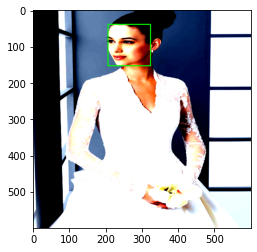

In [20]:
for images, annotations in data_loader:
  img = images[0].numpy().transpose(1,2,0).copy()

  
  print(img.dtype)
  for b in annotations[0][:, 1:]:
    print(b)
    x1 = int(b[0])
    y1 = int(b[1])
    x2 = int(b[2])
    y2 = int(b[3])
    
    
    
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0),2)

  plt.imshow(img)
  break

(682, 1024, 3)
uint8
[[1, 227, 382, 283, 425], [1, 885, 377, 948, 418]]
/content/WIDER_train/images/0--Parade/0_Parade_marchingband_1_117.jpg


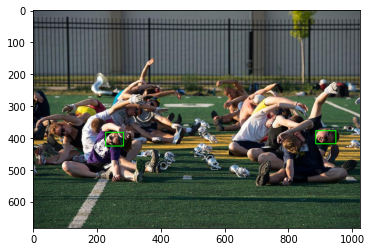

In [ ]:
for i, (box, paths) in enumerate(zip(lista, names)):
    
    if i==2:
      path = "/content/WIDER_train/images/" +paths
      #print(path)
      #img = Image.open(path)
      #img = np.asarray(img)
      #if path == "/content/WIDER_train/images/54--Rescue/54_Rescue_rescuepeople_54_29.jpg":
      img = Image.open(path)
      img = np.asarray(img)
      
      
      print(img.shape)
      print(img.dtype)
      print(box)
      print(path)

      for b in box:
        
        x1 = b[1]
        y1 = b[2]
        x2 = b[3]
        y2 = b[4]
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
      plt.imshow(img)
      

